In [1]:
using Random, Distributions
using Plots; gr(); # Using the Plotly Backend

In [2]:
gaussian(x, μ, v) = exp.(-0.5*(x.-μ).^2/v)/sqrt(2.0 *π*v);

In [3]:
x = collect(-10:.01:10)
y = gaussian(x, 0.0, 1.0);

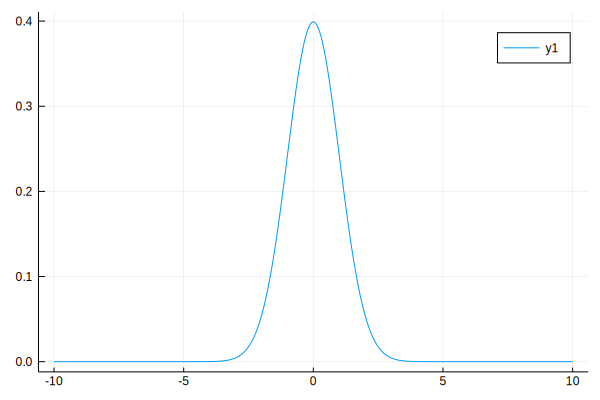

In [4]:
plot(x, y)

In [5]:
g = Normal(0, 1);

In [6]:
z = [ pdf(g, xx) for xx in x ]

2001-element Array{Float64,1}:
 7.69459862670642e-23  
 8.503421446798956e-23 
 9.396324532749071e-23 
 1.0381948798732402e-22
 1.1469812748239538e-22
 1.267040052182252e-22 
 1.399525866765051e-22 
 1.545710248779582e-22 
 1.7069932895435988e-22
 1.884916480826121e-22 
 2.0811768202028245e-22
 2.2976423056216597e-22
 2.536368954198933e-22 
 ⋮                     
 2.2976423056216597e-22
 2.0811768202028245e-22
 1.884916480826121e-22 
 1.7069932895435988e-22
 1.545710248779582e-22 
 1.399525866765051e-22 
 1.267040052182252e-22 
 1.1469812748239538e-22
 1.0381948798732402e-22
 9.396324532749071e-23 
 8.503421446798956e-23 
 7.69459862670642e-23  

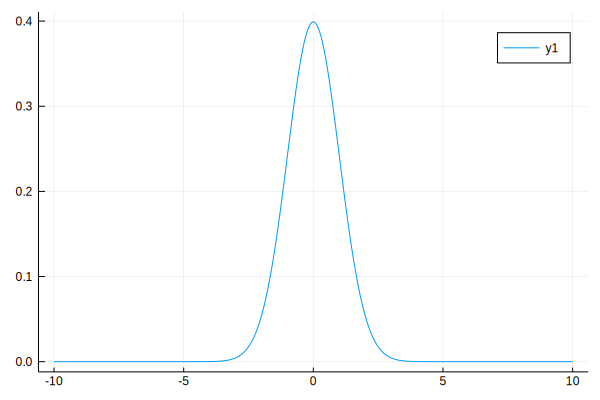

In [7]:
plot(x, z)

In [8]:
using Random, Distributions

In [9]:
function gaussian_prod(g1, g2)
    v1 = (g1.σ)^2
    v2 = (g2.σ)^2
    return Normal((v2*g1.μ + v1*g2.μ)/(v1+v2), (v1*v2/(v1+v2)))
end

function gaussian_sum(g1, g2)
    v1 = (g1.σ)^2
    v2 = (g2.σ)^2
    return Normal((g2.μ + g1.μ), (v2 + v1))
end

gaussian_sum (generic function with 1 method)

In [10]:
predicted_pos = Normal(10, .2)
measured_pos = Normal(11, .1)
estimated_pos = gaussian_prod(predicted_pos, measured_pos)

Normal{Float64}(μ=10.799999999999999, σ=0.008000000000000002)

In [11]:
pos = Normal(10, .2)
move = Normal(15, .7)
gaussian_sum(pos, move)

Normal{Float64}(μ=25.0, σ=0.5299999999999999)

In [12]:
process_var = 2.
sensor_var = 4.5
x = Normal(0, 400)
process_g = Normal(1, process_var)
sensor_g = Normal(0, sensor_var)
N = 25

25

In [15]:
using Printf

mutable struct Model
    x::Float64
    g_x::Normal
    g_v::Normal
    function Model(x, g_x, g_v)
        new(x, g_x, g_v)
    end
end

function update_model(model, dt)
    dx = rand(model.g_v)
    # @printf("dx: %f\n", dx)
    model.x += dx*dt
    # @printf("predict x: %f\n", model.x)
    rand_meas = rand(model.g_x)
    # @printf("rand meas x: %f\n", rand_meas)
    meas = model.x + rand_meas
    # @printf("meas x: %f\n", meas)
    return meas
end

update_model (generic function with 1 method)

In [16]:
model = Model(mean(x), sensor_g, process_g)

Model(0.0, Normal{Float64}(μ=0.0, σ=4.5), Normal{Float64}(μ=1.0, σ=2.0))

In [27]:
update_model(model, 1)

predict x: 2.704997
meas x: 2.446431


2.446431125119725

In [17]:
z = [ update_model(model, 1) for _ in 1:1:N]

25-element Array{Float64,1}:
 -4.672820660525966 
 -2.0743070887491193
  1.493139681348052 
 -8.495807566917897 
  9.938991925111798 
 -4.169167221517111 
  5.869306126898293 
 -2.4314765272796275
  7.679353768775731 
  9.780066420071858 
  6.830874545352873 
 -0.8807546571782048
 16.040335426764447 
  3.899750681447168 
 13.24861528792896  
  5.860186192267032 
 -2.4387635578665527
 12.584811104322608 
 14.430140677094812 
 15.055202081521061 
 17.128326241534513 
  9.39822077316868  
 12.110502911445888 
 24.472740270633523 
 16.781138376399525 

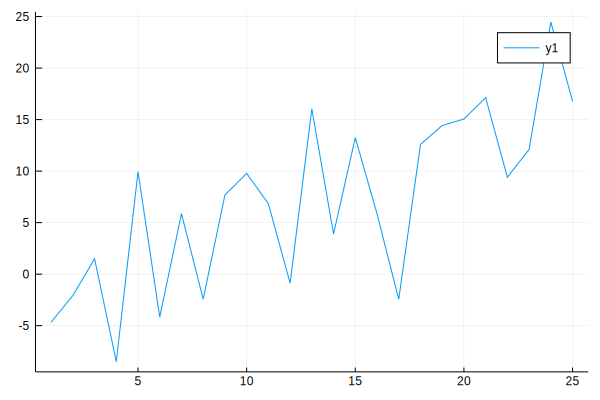

In [18]:
plot(z)

In [19]:
update(prior, likelihood) = gaussian_prod(prior, likelihood)
predict(pos, movement) = gaussian_prod(pos, movement)

predict (generic function with 1 method)

In [43]:
x = Normal(0, 400)

filter = []
priors = []
for d in z
    prior = predict(x, process_g)
    push!(priors, prior)
    likelihood = Normal(d, sensor_var)
    x = update(prior, likelihood)
    push!(filter, x)
end

In [53]:
μfilter = [i.μ for i in filter];
μpriors = [i.μ for i in priors];
σfilter = [i.σ for i in filter];
σpriors = [i.σ for i in priors];

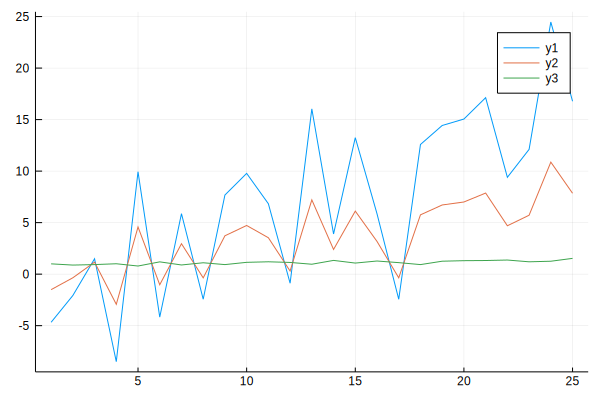

In [52]:
plot(z)
plot!(μfilter)
plot!(μpriors)

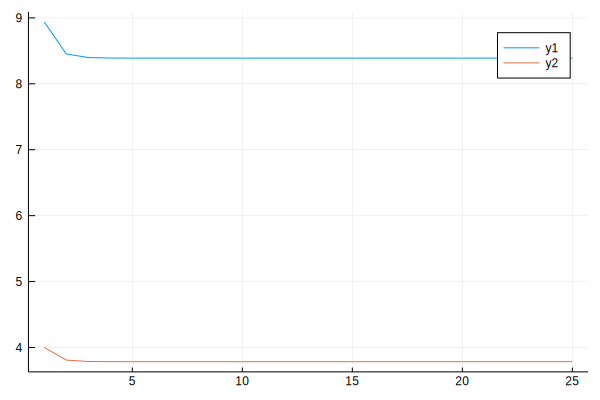

In [54]:
plot(σfilter)
plot!(σpriors)